# Battery Heater Thresholds

In [1]:
from glob import glob
from datetime import datetime, timedelta
import pandas as pd
from matplotlib import pyplot as plt
import parse

## File Input

Read all datasets found in the `SatelliteData` directory via Pandas. `Parse.readFile()` performs filtering and conversion: it changes the timestamps from milliseconds since epoch to Datetime objects, and rejects that differ from the epoch's median temperature by `INNER_BOUND = 15` or from the previous epoch's temperature by `OUTER_BOUND = 5`.

In [2]:
filepaths = glob('./SatelliteData/satellite*.csv')
dfs  = {} # Dictionary to hold dataframes
for path in filepaths:
    sat = path[25:-4] # pull out the HWID
    dfs[sat] = parse.readFile(path)

## Time Series View

Since we want the temperatures to stay above $0^\circ \text{C}$, we can check how effective our control schemes are by viewing the time series of each satellite's battery pack temperatures. In each graph, we can see the changing $\beta$ angle of the orbital plane (large scale variations), and the smaller thermal cycles from heaters turning on-and-off and satellites entering and exiting eclipse (local maxs and mins).

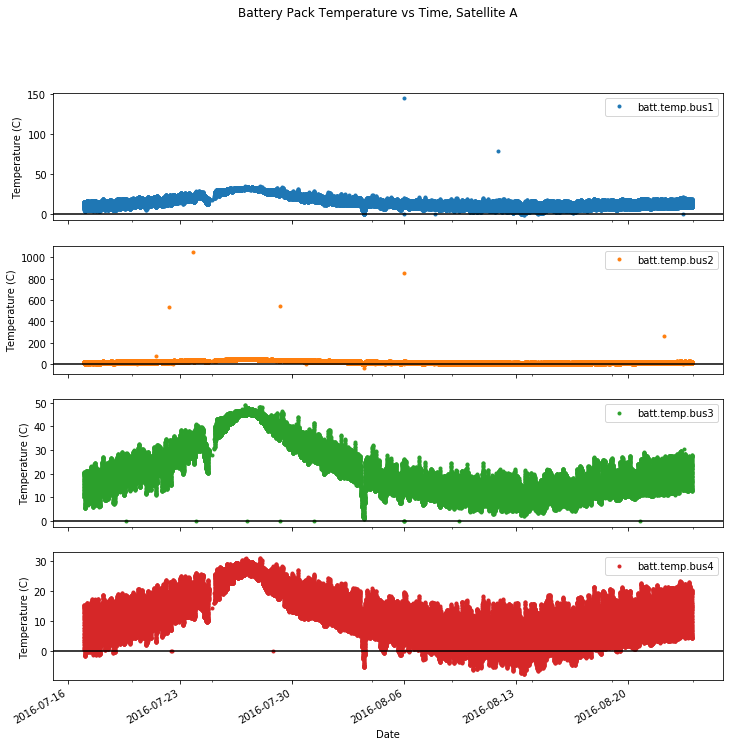

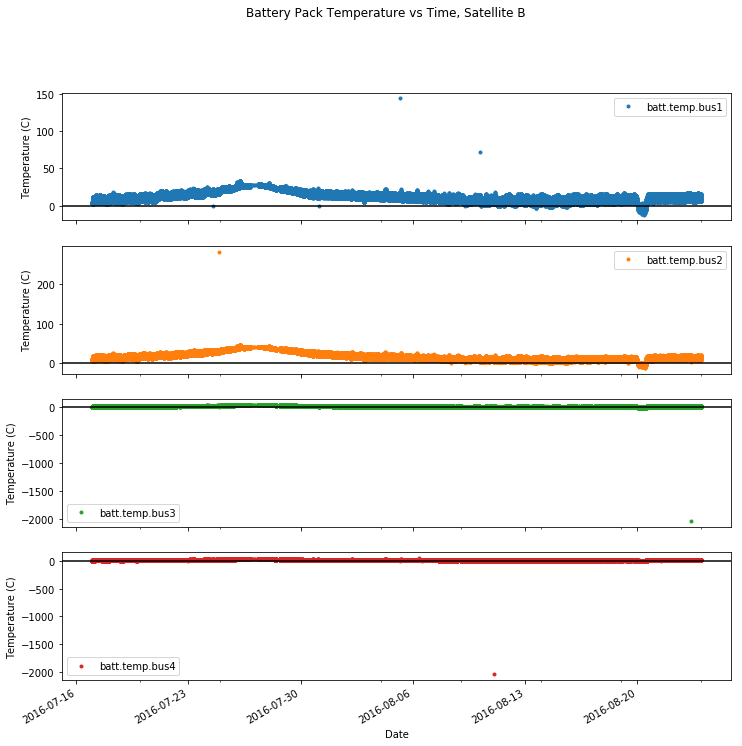

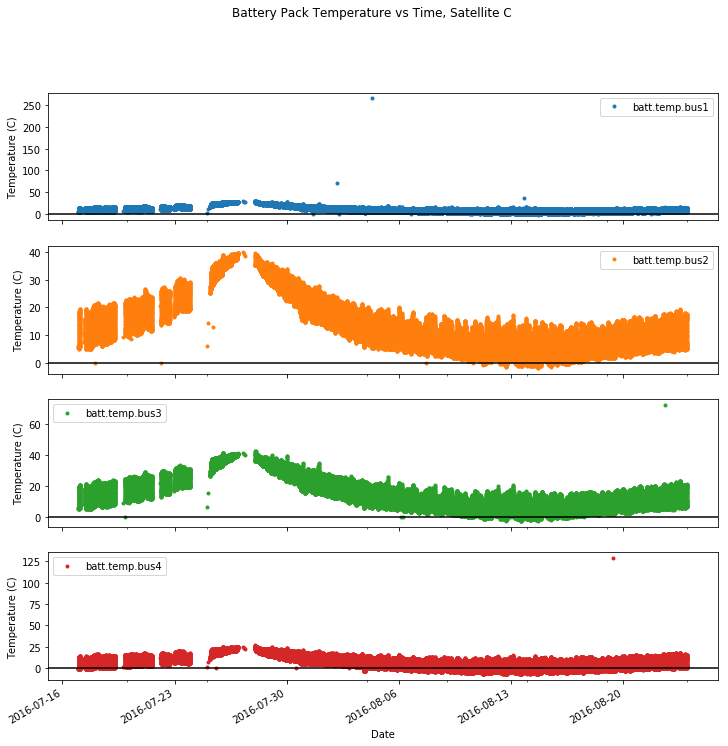

In [3]:
for sat in sorted(dfs.keys()):
    parse.plotTime(dfs[sat], sat)
plt.show()

One interesting thing to note are the minimas around 2016-08-04 on Satellite A and 2016-08-20 on Satellite B. These are large out-of-place variations across all battery packs. By taking a closer look at the event on Sat B, we can see that something changes on the satellite. The logging frequency decreases at the same time the temperatures start to drift below $0^\circ\text{C}$. This might indicate the satellite is not operating in a normal mode. Further information about the satellite during this period might shed additional light and allow these excursions below $0^\circ\text{C}$ to be excluded from analysis.

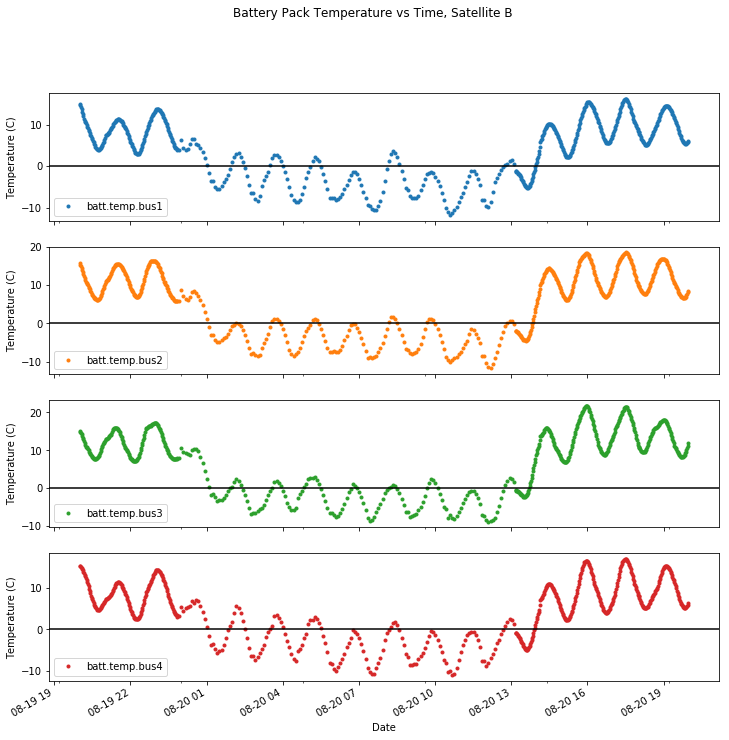

In [4]:
parse.plotTime(dfs['B'].query("(timestamp > datetime(2016,8,19,20)) and (timestamp < datetime(2016,8,20,20))"), 'B')
plt.show()

A single thermal cycle can be seen below. Note the inflection points when each pack crosses $5^\circ \text{C}$, a result of the pack heater turning on, and similarly for $T=10^\circ \text{C}$ for the heater off event. The temperature of Bus 4 can also be observed dropping below $0^\circ \text{C}$.

Interestingly, Bus 3 never drops below the activation threshold for the heater, yet it still heats up. This might happen for a few reasons: heat transfer through the sat from the other batter packs or other heaters, exiting eclipse, increased power draw, or the Bus 3 heater is activated independently of the the Bus 3 temperature. I'm going to assume that whatever is causing this is independent of the control law posited in the problem statement (each pack independantly switches on a heater when the individual temperature drops below a threshold, then switches the heater off when the temperature rises above a threshold).

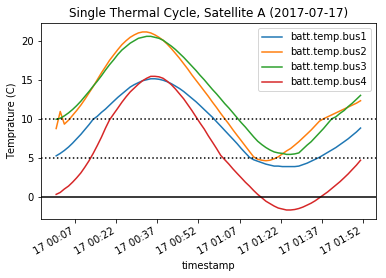

In [5]:
ax = dfs['A'].head(75).plot(x='timestamp', 
                            y=['batt.temp.bus1', 'batt.temp.bus2', 'batt.temp.bus3', 'batt.temp.bus4'], 
                            title='Single Thermal Cycle, Satellite A (2017-07-17)')
ax.axhline(y=5, color='k', linestyle=':')
ax.axhline(y=10,color='k', linestyle=':')
ax.axhline(y=0, color='k')
ax.set_ylabel('Temprature (C)');
plt.show()

## Temperature Distribution

A better way to quantitatively analyze how well the temperature stays in our bounds is by looking at the temperature distribution. We're specifically interested in the frequency of temperatures below $0^\circ\text{C}$, which seem to occur with a greater frequency on Satellite C (where the lower thresholds are in-place) and on Bus 4 across all satellites. Bus 4 might be colder because it's further away from other components, under a lower load, better insulated, always opposite or shaded from the sun, or just improperly calibrated. The most likely explanation is that it is on the "cold" side of the satellite and doesn't receive as much direct sun. Similarly Bus 1 is colder than Busses 2 and 3 across all satellites, probably from again receiving less ambient heat, and Busses 2 and 3 record the warmest temperatures.

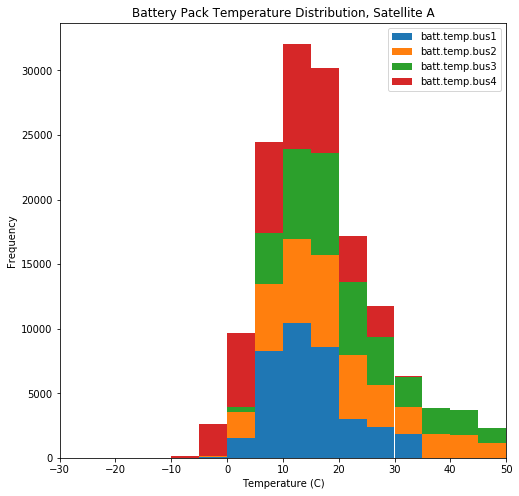

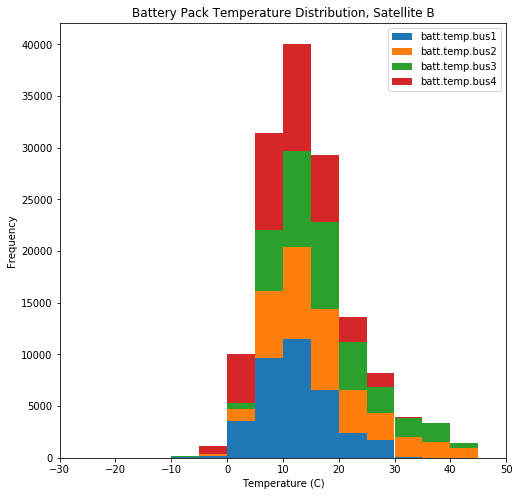

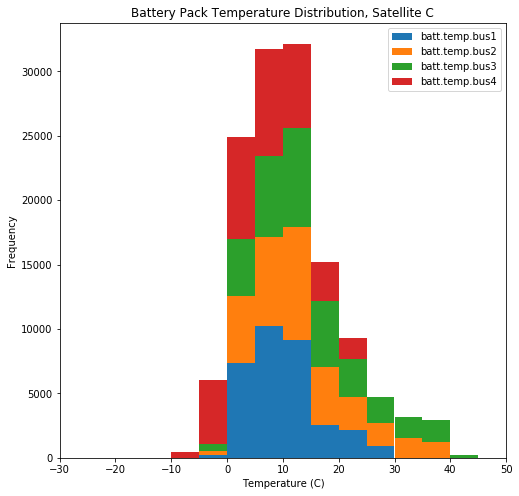

In [6]:
for sat in sorted(dfs.keys()):
    parse.plotDist(dfs[sat], sat)
plt.show()

## Filtering by Threshold

In order to examine how effective the new heating thresholds are, we can partition the data into an active experiment set (with $T_{\text{on}}/T_{\text{off}} = 11/16^\circ \text{C}$) and a set where the experiment is inactive ($T_{\text{on}}/T_{\text{off}} = 5/10^\circ \text{C}$).

In [7]:
activeA = dfs['A'].query("timestamp >= datetime.fromisoformat('2016-07-20T23:09:46')")
inactiveA = dfs['A'].query("timestamp < datetime.fromisoformat('2016-07-20T23:09:46')")

activeB = dfs['B'].query("timestamp >= datetime.fromisoformat('2016-07-21T02:34:52')")
# Uncomment to filter out anomalous Sat. B operation
#activeB = activeB.query("(timestamp < datetime(2016,8,19,23)) or (timestamp > datetime(2016,8,20,14))")
inactiveB = dfs['B'].query("timestamp < datetime.fromisoformat('2016-07-21T02:34:52')")

One interesting thing to note is that both satellites reboot shortly after the new thresholds become active. Presumably, this is happening during a pass with a ground station, so the thresholds become active within minutes.

In [8]:
activeA.head()

,timestamp,batt.temp.bus1,batt.temp.bus2,batt.temp.bus3,batt.temp.bus4,sc.bootcount
3877,2016-07-20 23:10:38.054,10.4375,13.50,15.4375,5.375,NaN
3878,2016-07-20 23:10:42.540,NaN,NaN,NaN,NaN,228.0
3879,2016-07-20 23:11:23.967,NaN,NaN,NaN,NaN,228.0
3880,2016-07-20 23:12:07.113,10.1875,12.75,14.7500,4.875,NaN
3881,2016-07-20 23:12:07.297,10.1875,12.75,14.7500,4.875,NaN


In [9]:
activeB.head(8)

,timestamp,batt.temp.bus1,batt.temp.bus2,batt.temp.bus3,batt.temp.bus4,sc.bootcount
4099,2016-07-21 02:36:00.926,NaN,NaN,NaN,NaN,16.0
4100,2016-07-21 02:36:07.097,10.0625,16.2500,15.5625,9.2500,NaN
4101,2016-07-21 02:36:58.184,NaN,NaN,NaN,NaN,16.0
4102,2016-07-21 02:37:15.368,9.9375,16.0000,15.3125,9.1250,NaN
4103,2016-07-21 02:37:37.085,9.8750,15.9375,15.2500,9.0625,NaN
4104,2016-07-21 02:37:49.522,NaN,NaN,NaN,NaN,16.0
4105,2016-07-21 02:39:08.058,9.8125,15.6875,15.0000,9.0000,NaN
4106,2016-07-21 02:40:37.121,9.7500,15.5625,14.8750,8.9375,NaN


The datasets are combined together, then we can again look at the time series and distribution of the temperatures. The information about which bus each reading comes from has been dropped because we're less interested in which satellite and battery pack a particular temperature comes from; instead we're concerned about the overall impact of the threshold changes.

In [10]:
active = pd.concat([activeA, activeB], keys=['A', 'B'])
inactive = pd.concat([inactiveA, inactiveB, dfs['C']], keys=['A', 'B', 'C'])

With the higher thresholds active, we can see that Satellites A and B have similar temperatures. Satellite B seems to vary less resulting in less recorded temperatures below $0^\circ\text{C}$ (excepting its anomaly around 8/20).

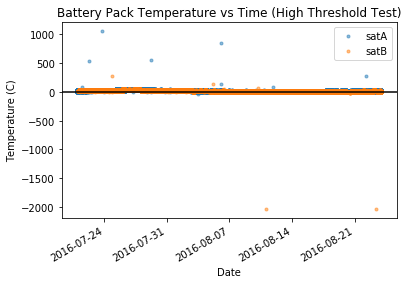

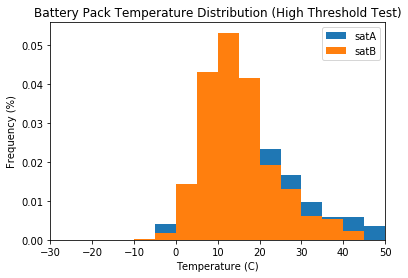

In [11]:
active_reduced = parse.plotReduce(active,'High Threshold Test')
plt.show()

The control for the experiment is presented below. Note that the performance of Satellites A and B track with Satellite C before they change thresholds. This indicates that Satellite C is representative of A and B had they maintained the lower thresholds. Additional data from before the experiment begins would further confirm this.

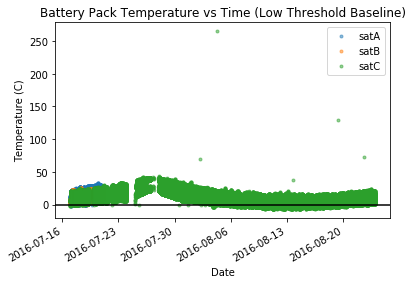

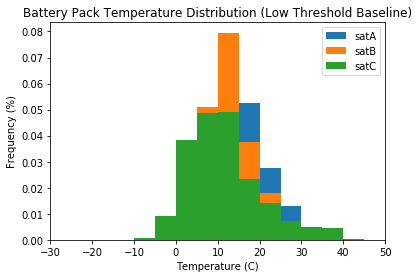

In [12]:
inactive_reduced = parse.plotReduce(inactive,'Low Threshold Baseline')
plt.show()

The histograms show that higher threshold did indeed have fewer samples below $0^\circ \text{C}$. Let's make a numerical comparision.

In [13]:
count_act_below   = len(active_reduced.query("satA < 0 or satB < 0"))
count_act_total   = len(active_reduced)
act_percent = 100 * count_act_below / float(count_act_total)
print('Count Active <= 0C: \t%d(/%d, %.2f%%)' % (count_act_below, count_act_total, act_percent))

count_inact_below   = len(inactive_reduced.query("satA < 0 or satB < 0 or satC < 0"))
count_inact_total   = len(inactive_reduced)
inact_percent = 100 * count_inact_below / float(count_inact_total)
print('Count Inactive <= 0C: \t%d(/%d, %.2f%%)' % (count_inact_below, count_inact_total, inact_percent))

Count Active <= 0C: 	4008(/255924, 1.57%)
Count Inactive <= 0C: 	6387(/162048, 3.94%)


This works out to be a substantial decrease: an over 60% reduction in samples below the desired temperature of $0^\circ \text{C}$.

In [14]:
decrease = 100 * (act_percent - inact_percent) / inact_percent
print('Effect of threshold change: %.2f%%' % decrease)

Effect of threshold change: -60.27%


Unfortunately, the higher thresholds don't completely prevent the satellite from reading temperatures below $0^\circ \text{C}$. To determine if the result is acceptable, a few figures can be calculated: the total amount of time spent below $0^\circ \text{C}$ would reveal how the long-term degradation of the battery is progressing, and the average length of each excursion below freezing could show the short-term impact (how long the sat operates in reduced power). In light of other considerations, the higher thresholds (even though they don't totally prevent low temperatures) might be acceptable.

In [15]:
active_freezetime = timedelta()
active_tottime = timedelta()
active_count = 0
for sat in ['A', 'B']:
    count, freezetime = parse.countCycles(active.loc[sat], 0, 0)
    active_count += count
    active_freezetime += freezetime
    active_tottime += active.loc[sat].iloc[-1]['timestamp'] - active.loc[sat].iloc[0]['timestamp']
print('Time Below Freezing (High Thresholds): %d excursions, %.2f battery hours(/%.2f total battery hours, %.2f%%),\n\tavg. excursion %.0f minutes' \
     % (active_count, active_freezetime.total_seconds()/float(60*60), \
        4*active_tottime.total_seconds()/float(60*60), 100*active_freezetime/(4*active_tottime), \
        active_freezetime.total_seconds()/(60*active_count)))

inactive_freezetime = timedelta()
inactive_tottime = timedelta()
inactive_count = 0
for sat in ['A', 'B', 'C']:
    count, freezetime = parse.countCycles(inactive.loc[sat], 0, 0)
    inactive_count += count
    inactive_freezetime += freezetime
    inactive_tottime += inactive.loc[sat].iloc[-1]['timestamp'] - inactive.loc[sat].iloc[0]['timestamp']
print('Time Below Freezing (Low Thresholds): %d excursions, %.2f battery hours(/%.2f total battery hours, %.2f%%),\n\tavg. excursion %.0f minutes' \
     % (inactive_count, inactive_freezetime.total_seconds()/float(60*60), \
        4*inactive_tottime.total_seconds()/float(60*60), 100*inactive_freezetime/(4*inactive_tottime), \
        inactive_freezetime.total_seconds()/(60*inactive_count)))

Time Below Freezing (High Thresholds): 374 excursions, 128.28 battery hours(/6520.71 total battery hours, 1.97%),
	avg. excursion 21 minutes
Time Below Freezing (Low Thresholds): 500 excursions, 164.40 battery hours(/4422.80 total battery hours, 3.72%),
	avg. excursion 20 minutes


When the anomalous operation of Satellite B is excluded from analysis, the difference in operation is even more stark. The percentage of time below the $0^\circ\text{C}$ threshold is $1.31\%$, and the average excursion length drops to $17$ minutes. Since filtering out those $15$ hours changes the avg. excursion length from being longer than the control to shorter than the control, I'd seriously want to investigate to determine how Satellite B is operating during that timespan and whether or not the heaters are following the normal control law.

## Effects of Beta Angle

Looking at the whole time series for any set of data, a full period of $\beta$ angles can be observed. When $\beta$ is maximized (around 2016-07-29) the time spent in sunlight is maximized, resulting in higher temperatures across the battery packs. When $\beta = 0^\circ$ (around 2016-08-13) the time spent in eclipse is maximize, which causes lower temperatures across the battery packs. Additionally, the heaters are forced to be much more active, both in frequency and duration of "on" periods. Since the satellite doesn't receive as much sunlight it is both cooler and harder to warm up without the additional thermal input of the sun.

## Other Considerations
Though the higher thresholds were more effective in maintaining the battery temperature (only $1.55\%$ samples with $T<=0^\circ\text{C}$), there are several possible drawbacks to this approach:

 * Temperature of other components:
 
    - Similar to the batteries' operating temperatures, the other components of the Doves have ideal temperatures. In particular, the telescopic lens that allows the Dove to image the Earth has an ideal temperature where it is in focus. Heating the batteries during an imaging operation might cause the lens to go out of focus, to the detriment of the final product. Other issues might arise through thermal interference with the on-board computers, radios, reaction wheels, and other components.
 
 * Wear and tear on patch heaters:
     - The patch heaters have a certain lifespan that is primarily impacted by total operating time and total power cycles. Running them more often decreases the availible lifespan, increasing the chance of heater failure and performace degradation. See below for calculation of heater workload. Even though the difference between the two thresholds is $5^\circ \text{C}$ for both configurations, the satellite is forced to work harder to maintain the higher temperatures. Over the course of the experiment, the higher thresholds result in each heater being cycled an additional time per day and powered on for an additional 4 hours each day. These values were found assuming that each heater functions independantly.

 * Potential differences:
     - Each heater performs slightly differently. While the higher thresholds might succeed on one battery pack, they might be ineffective on another, even on the same satellite. Furthermore, different satellites have even more different performance characteristics, and different orbital planes might exhibit even more differences due to $\beta$ angle variations. Fleetwide testing could either ensure that the higher thresholds (if accepted) result in a acceptable percentage of success (time below $0^\circ \text{C}$), or the thresholds could be set for each satellite individually. A fleet-wide process could be automated to start each satellite at a particular set of thresholds, then evaluate the temperature data to see if the thresholds need to be raised or lowered (a temperature controller controller, if you will).
 

In [16]:
active_ontime = timedelta()
active_time = timedelta()
active_count = 0
for sat in ['A', 'B']:
    count, ontime = parse.countCycles(active.loc[sat], 11, 16)
    active_count += count
    active_ontime += ontime
    active_time += active.loc[sat].iloc[-1]['timestamp'] - active.loc[sat].iloc[0]['timestamp']
print('Patch Heater Cycles (High Thresholds): %d over %s\n\t(%.2f cycles per heater per day, approx. %.2f%% duty cycle, or %.2f hours per heater per day)' \
        % (active_count, str(active_time), \
           24*60*60*active_count/(4*active_time.total_seconds()), \
           100*active_ontime/(4*active_time), 24*active_ontime/(4*active_time)))

inactive_ontime = timedelta()
inactive_time = timedelta()
inactive_count = 0
for sat in ['A', 'B', 'C']:
    count, ontime = parse.countCycles(inactive.loc[sat], 5, 10)
    inactive_count += count
    inactive_ontime += ontime
    inactive_time += inactive.loc[sat].iloc[-1]['timestamp'] - inactive.loc[sat].iloc[0]['timestamp']
print('Patch Heater Cycles (Low Thresholds): %d over %s\n\t(%.2f cycles per heater per day, approx. %.2f%% duty cycle, or %.2f hours per heater per day)' \
        % (inactive_count, str(inactive_time), \
           24*60*60*inactive_count/(4*inactive_time.total_seconds()), \
           100*inactive_ontime/(4*inactive_time), 24*inactive_ontime/(4*inactive_time)))

Patch Heater Cycles (High Thresholds): 2585 over 67 days 22:10:35.160000
	(9.51 cycles per heater per day, approx. 45.44% duty cycle, or 10.90 hours per heater per day)
Patch Heater Cycles (Low Thresholds): 1604 over 46 days 01:42:00.012000
	(8.70 cycles per heater per day, approx. 28.22% duty cycle, or 6.77 hours per heater per day)
